In [550]:
import numpy, matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import torch, torch.nn as nn, torch.optim as optim
from sklearn.svm import OneClassSVM
import scipy.spatial
import scipy.ndimage

# Data generation

In [277]:
phi_samp, rmsf = numpy.loadtxt('dae/rmsf.txt', dtype=complex).T
rmsf = rmsf[500:-500]
N = 10000
phi_channels = 1000
phis = numpy.linspace(-1000, 1000, phi_channels)
sigma = 2e-5

In [278]:
def generate_spectra(complexity=2):
    depths = numpy.random.uniform(-800, 800, size=(N, complexity))
    depth_indices = numpy.searchsorted(phis, depths)
    phases = numpy.random.uniform(-numpy.pi, numpy.pi, size=(N, complexity))
    amps = numpy.random.uniform(0.0005, 0.0020, size=(N, complexity))
    spectra = numpy.zeros(shape=(N, len(phis)), dtype='complex')
    for i in range(N):
        spectra[i, depth_indices[i]] += (amps[i] * (
            numpy.cos(phases[i]) + 1j * numpy.sin(phases[i])))
    # Add a little noise.
    noisy_spectra = numpy.zeros_like(spectra)
    for i in range(N):
        noise = numpy.random.normal(scale=sigma, size=spectra[i].shape)
        noise = noise + 1j * numpy.random.normal(
            scale=sigma, size=spectra[i].shape)
        noisy_spectra[i] = noise + spectra[i]
    # Convolve the RMSF.
    obs_spectra = numpy.zeros_like(spectra)
    for i in range(N):
        obs_spectra[i] = numpy.convolve(
            noisy_spectra[i], rmsf)[499:-500]
    return spectra, obs_spectra

In [279]:
simple_spectra_true, simple_spectra = generate_spectra(complexity=1)

In [280]:
complex_spectra_true, complex_spectra = generate_spectra(complexity=2)

In [281]:
obs_spectra = numpy.concatenate([simple_spectra, complex_spectra], axis=0)
true_spectra = numpy.concatenate([simple_spectra_true, complex_spectra_true], axis=0)
labels = numpy.zeros(N * 2, dtype=bool)
labels[:N] = False
labels[N:] = True

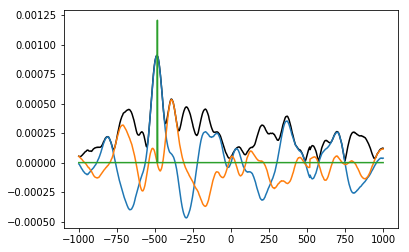

In [282]:
plt.plot(phis, abs(obs_spectra[0]), c='black')
plt.plot(phis, obs_spectra[0].real)
plt.plot(phis, obs_spectra[0].imag)
plt.plot(phis, abs(true_spectra[0]))

In [283]:
# Normalise and centre.
X = obs_spectra - obs_spectra.mean(axis=0, keepdims=True)
X /= X.std(axis=0, keepdims=True)

In [284]:
X_real = numpy.concatenate([X.real, X.imag], axis=1)
X_real.shape

(20000, 2000)

# Model tests

In [729]:
def test_model(features):
    features = features - features.mean(axis=0, keepdims=True)
    features /= features.std(axis=0, keepdims=True)
    train_X, test_X, train_y, test_y = train_test_split(
        features, labels, test_size=0.2, shuffle=True, random_state=0)
    models = [LogisticRegression, GaussianNB]
    scores = []
    trained_models = []
    for model in models:
        print(model.__name__)
        model = model()
        model.fit(train_X, train_y)
        score = model.score(test_X, test_y)
        print(score)
        print()
        scores.append(score)
        trained_models.append(model)
    # Try OneClassSVM
#     training_point_dists = scipy.spatial.distance.pdist(train_X[~train_y])
#     pp = [10, 30, 50]
#     quantiles = numpy.percentile(training_point_dists, pp)
    print('OneClassSVM')
#     for p, quantile in zip(pp, quantiles):
    model = OneClassSVM(kernel='linear')
#         print('\t{}th quantile ({:.03e})'.format(p, quantile))
    model.fit(train_X[~train_y])  # Train only on simple sources.
    pred_y = model.predict(test_X) == (-1)
    score = (pred_y == test_y).mean()
    scores.append(score)
#     print('\t{}'.format(score))
    print('{}'.format(score))
    print()
    trained_models.append(model)
    return scores, trained_models

# PCA

In [286]:
pca = PCA(n_components=64)

In [287]:
X_pca = pca.fit_transform(X_real)

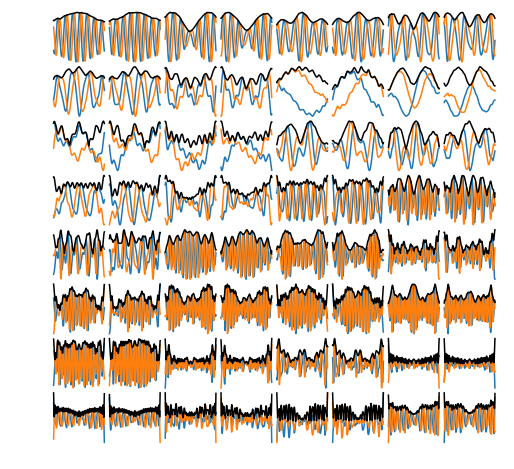

In [288]:
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    real, imag = pca.components_[i][:phi_channels], pca.components_[i][phi_channels:]
    plt.plot(real)
    plt.plot(imag)
    plt.plot(abs(real + 1j * imag), c='k')
    plt.axis('off')
plt.subplots_adjust(hspace=0, wspace=0)

In [730]:
test_model(X_pca);

LogisticRegression
0.51

GaussianNB
0.7015

OneClassSVM
0.4905



# Autoencoder (2-layer)

In [295]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Linear(2000, 256),
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
        )
        self.decode = nn.Sequential(
            nn.Linear(64, 256),
            nn.Tanh(),
            nn.Linear(256, 2000),
        )
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [296]:
torch_X_real = torch.from_numpy(X_real).float()

In [297]:
# train_autoencoder.py
ae = Autoencoder().float()
ae.load_state_dict(torch.load('ae.dat', map_location='cpu'))
ae.eval()

Autoencoder(
  (encode): Sequential(
    (0): Linear(in_features=2000, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
  )
  (decode): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=2000, bias=True)
  )
)

In [731]:
test_model(ae.encode(torch_X_real).detach().numpy());

LogisticRegression
0.62

GaussianNB
0.687

OneClassSVM
0.558



In [299]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N x 1000 x 2
        self.encode1 = nn.Sequential(
            nn.Conv1d(2, 32, 3, padding=1),
            nn.Tanh(),
        )
        # N x 1000 x 32
        self.mpool1 = nn.MaxPool1d(4, return_indices=True)
        # N x 250 x 32
        self.encode2 = nn.Sequential(
            nn.Conv1d(32, 16, 3, padding=1),
            nn.Tanh(),
        )
        # N x 250 x 16
        self.mpool2 = nn.MaxPool1d(5, return_indices=True)

        # N x 50 x 16
        self.umpool2 = nn.MaxUnpool1d(5)
        self.decode2 = nn.Sequential(
            nn.ConvTranspose1d(16, 32, 3, padding=1),
            nn.Tanh(),
        )
        self.umpool1 = nn.MaxUnpool1d(4)
        self.decode1 = nn.Sequential(
            nn.ConvTranspose1d(32, 2, 3, padding=1),
        )
        
    def encode(self, x):
        x = self.encode1(x)
        x, idx1 = self.mpool1(x)
        x = self.encode2(x)
        x, idx2 = self.mpool2(x)
        return x, (idx1, idx2)
    
    def decode(self, x, idx):
        idx1, idx2 = idx
        x = self.umpool2(x, idx2)
        x = self.decode2(x)
        x = self.umpool1(x, idx1)
        x = self.decode1(x)
        return x

    def forward(self, x):
        x, idx = self.encode(x)
        x = self.decode(x, idx)
        return x

In [300]:
torch_X = torch.from_numpy(numpy.stack([X.real, X.imag], axis=1)).float()
torch_X.shape

torch.Size([20000, 2, 1000])

In [301]:
cae = ConvolutionalAutoencoder().float()
cae.load_state_dict(torch.load('cae.dat', map_location='cpu'))
cae.eval()

ConvolutionalAutoencoder(
  (encode1): Sequential(
    (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Tanh()
  )
  (mpool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (encode2): Sequential(
    (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Tanh()
  )
  (mpool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (umpool2): MaxUnpool1d(kernel_size=(5,), stride=(5,), padding=(0,))
  (decode2): Sequential(
    (0): ConvTranspose1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Tanh()
  )
  (umpool1): MaxUnpool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (decode1): Sequential(
    (0): ConvTranspose1d(32, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  )
)

In [302]:
cae_encoded = cae.encode(torch_X)[0].detach().numpy()
cae_encoded.shape

(20000, 16, 50)

In [732]:
test_model(cae_encoded.reshape(-1, 16 * 50));

LogisticRegression
0.71825

GaussianNB
0.67325

OneClassSVM
0.68375



# Deconvolving autoencoder

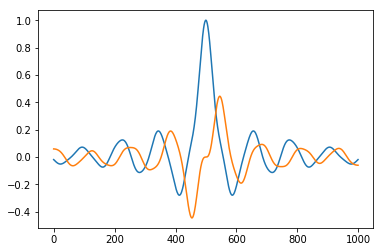

In [306]:
plt.plot(rmsf.real)
plt.plot(rmsf.imag)

torch.Size([10, 1, 1001])

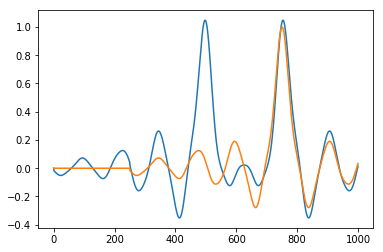

In [316]:
test_vec = torch.zeros((10, 1, 1000))
test_vec[0, 0, 500] = 1
test_vec[0, 0, 750] = 1
test_vec[1, 0, 750] = 1
convRMSF = nn.functional.conv1d(test_vec, real_rmsf[:, :, :], padding=500)
plt.plot(convRMSF.numpy()[0, 0])
plt.plot(convRMSF.numpy()[1, 0])
convRMSF.shape

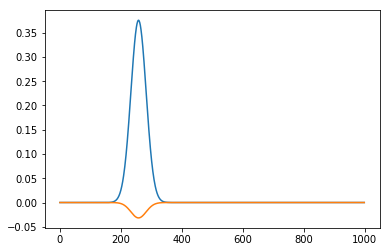

In [558]:
# It'll be easier to predict if we smooth out the spectrum a little.
# This corresponds to saying we're ok with the autoencoder being a little bit wrong.
# For that reason it's best if we have a wide Gaussian. About as wide as the RMSF I think.
tru_real = scipy.ndimage.gaussian_filter1d(tru.real, sigma=25, axis=-1, mode='constant')
tru_imag = scipy.ndimage.gaussian_filter1d(tru.imag, sigma=25, axis=-1, mode='constant')
torch_X_true = torch.from_numpy(numpy.stack([tru_real, tru_imag], axis=1)).float()
torch_X_true = torch_X_true / torch_X_true.max()
plt.plot(torch_X_true[0, 0].numpy())
plt.plot(torch_X_true[0, 1].numpy())

In [682]:
class DeconvolvingAutoencoder(nn.Module):
    loss_fn = nn.MSELoss()

    def __init__(self, rmsf, final_conv=True):
        super().__init__()
        self.real_rmsf = torch.from_numpy(rmsf.real.reshape(1, 1, -1)).float()
        self.imag_rmsf = torch.from_numpy(rmsf.imag.reshape(1, 1, -1)).float()

        # N x 1000 x 2
        self.encode1 = nn.Sequential(
            nn.Conv1d(2, 32, 3, padding=1),
            nn.Tanh(),
        )
        # N x 1000 x 32
        self.mpool1 = nn.MaxPool1d(4, return_indices=True)
        # N x 250 x 32
        self.encode2 = nn.Sequential(
            nn.Conv1d(32, 16, 3, padding=1),
            nn.Tanh(),
        )
        # N x 250 x 16
        self.mpool2 = nn.MaxPool1d(5, return_indices=True)

        # N x 50 x 16
        self.umpool2 = nn.MaxUnpool1d(5)
        self.decode2 = nn.Sequential(
            nn.ConvTranspose1d(16, 32, 3, padding=1),
            nn.Tanh(),
        )
        self.umpool1 = nn.MaxUnpool1d(4)
        self.decode1 = nn.Sequential(
            nn.ConvTranspose1d(32, 2, 3, padding=1),
            nn.Tanh(),
        )
        
        self.final_conv = final_conv
        if self.final_conv:
            self.out_conv_real = nn.Parameter(torch.randn((1, 1, 1000)) * 0.01, requires_grad=True)
            self.out_conv_imag = nn.Parameter(torch.randn((1, 1, 1000)) * 0.01, requires_grad=True)
            self.final_tanh = nn.Tanh()
    
    def conv_RMSF(self, x):
        x_real = x[:, 0, :].view((x.shape[0], 1, x.shape[2]))
        x_imag = x[:, 1, :].view((x.shape[0], 1, x.shape[2]))
        conv_real = nn.functional.conv1d(x_real, self.real_rmsf, padding=500)
        conv_imag = nn.functional.conv1d(x_imag, self.imag_rmsf, padding=500)
        return torch.cat([conv_real, conv_imag], dim=1)
    
    def conv_final(self, x):
        x_real = x[:, 0, :].view((x.shape[0], 1, x.shape[2]))
        x_imag = x[:, 1, :].view((x.shape[0], 1, x.shape[2]))
        conv_real = nn.functional.conv1d(x_real, self.out_conv_real, padding=500)
        conv_imag = nn.functional.conv1d(x_imag, self.out_conv_imag, padding=500)
        return torch.cat([conv_real, conv_imag], dim=1)
        
    def encode(self, x):
        x = self.encode1(x)
        x, idx1 = self.mpool1(x)
        x = self.encode2(x)
        x, idx2 = self.mpool2(x)
        return x, (idx1, idx2)
    
    def decode(self, x, idx):
        idx1, idx2 = idx
        x = self.umpool2(x, idx2)
        x = self.decode2(x)
        x = self.umpool1(x, idx1)
        x = self.decode1(x)
        return x

    def forward(self, x):
        conv = x = self.conv_RMSF(x)
        x, idx = self.encode(x)
        conv_recon = self.decode(x, idx)
        if self.final_conv:
            recon = self.final_tanh(self.conv_final(conv_recon))[:, :, :-1]
        else:
            recon = None
        return conv[:, :, :-1], conv_recon, recon
    
    @classmethod
    def loss(cls, init, conv, conv_recon, init_recon, alpha=0.5):
        loss_conv = cls.loss_fn(conv_recon, conv)
        if self.final_conv:
            loss_e2e = cls.loss_fn(init_recon, init)
            return alpha * loss_conv + (1 - alpha) * loss_e2e
            
        return loss_conv

In [683]:
dcae = DeconvolvingAutoencoder(rmsf)
state_dict = torch.load('dcae500.dat', map_location='cpu')
dcae.load_state_dict(state_dict)
dcae.eval()
# optimiser = optim.Adagrad(dcae.parameters(), lr=1e-3)
# losses = []

DeconvolvingAutoencoder(
  (encode1): Sequential(
    (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Tanh()
  )
  (mpool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (encode2): Sequential(
    (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Tanh()
  )
  (mpool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (umpool2): MaxUnpool1d(kernel_size=(5,), stride=(5,), padding=(0,))
  (decode2): Sequential(
    (0): ConvTranspose1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Tanh()
  )
  (umpool1): MaxUnpool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (decode1): Sequential(
    (0): ConvTranspose1d(32, 2, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Tanh()
  )
  (final_tanh): Tanh()
)

In [684]:
# e = 100
# batch_size = 10
# for e in tqdm(range(n_epochs)):
#     bar = tqdm(total=2000)
#     torch_X_true_ = torch_X_true[torch.randperm(len(torch_X_true))]
#     for subset_i in (range(0, len(torch_X_true_), batch_size)):
#         optimiser.zero_grad()
#         subset = torch_X_true_[subset_i:subset_i + batch_size]
#         recons = dcae.forward(subset)
#         loss = dcae.loss(subset, *recons)
#         loss.backward()
#         optimiser.step()
#         losses.append(loss.item())
#         bar.postfix = '{:0.4e}'.format(loss.item())
#         bar.update(1)

10000

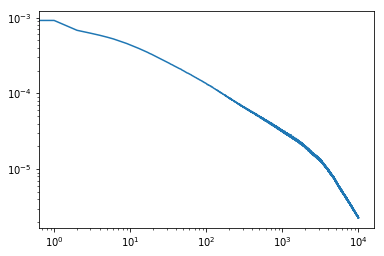

In [685]:
with open('slurmout.dat') as f:
    data = f.read()
    start = data.find('[0.0')
    losses = eval(data[start:])
    plt.plot(losses)
    plt.yscale('log')
    plt.xscale('log')
len(losses)

In [686]:
recons = [i.detach().numpy() for i in dcae.forward(torch_X_true_[:10])]

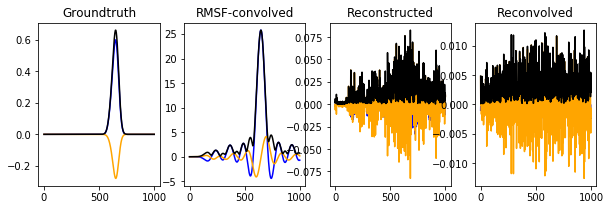

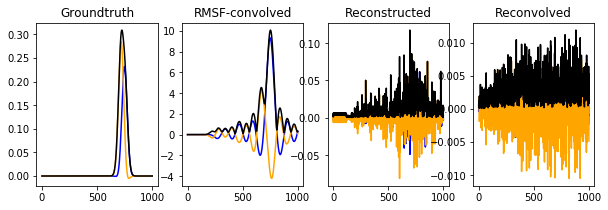

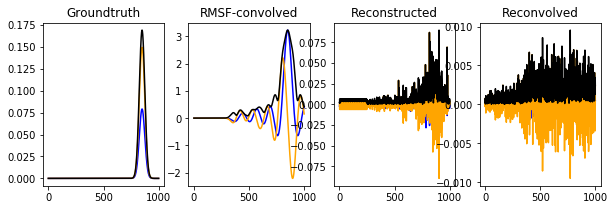

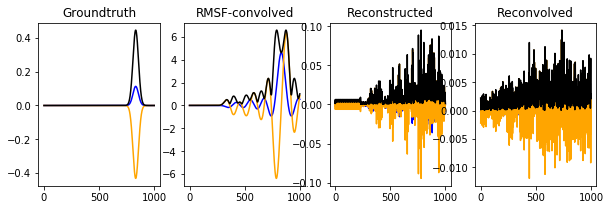

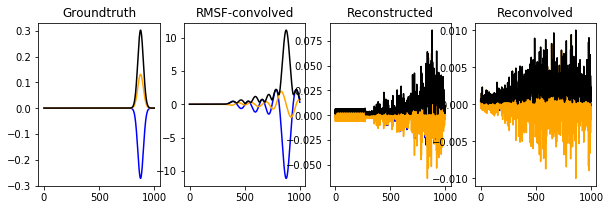

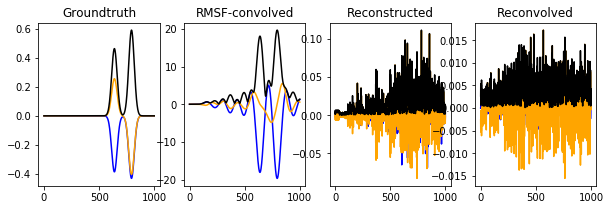

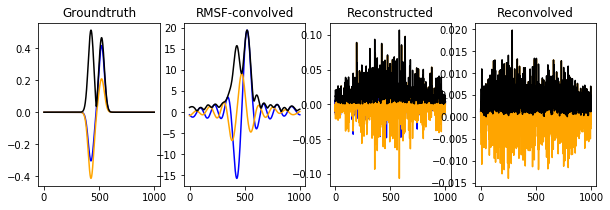

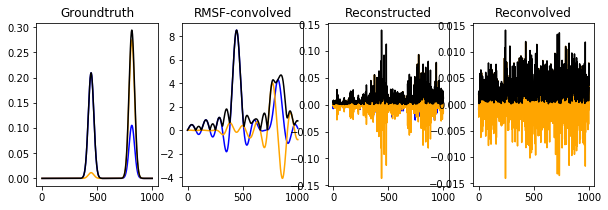

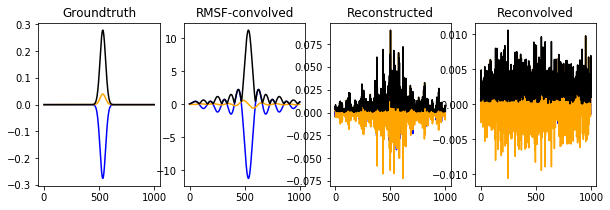

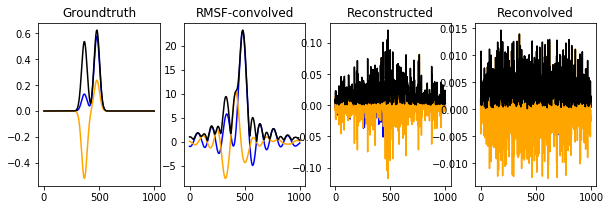

In [687]:
for i in range(10):
    plt.figure(figsize=(10, 3))
    
    plt.subplot(1, 4, 1)
    plt.title('Groundtruth')
    plt.plot(torch_X_true_[i, 0].numpy(), c='b')
    plt.plot(torch_X_true_[i, 1].numpy(), c='orange')
    plt.plot(numpy.sqrt(torch_X_true_[i, 0].numpy() ** 2 + torch_X_true_[i, 1].numpy() ** 2), c='k')
    
    plt.subplot(1, 4, 2)
    plt.title('RMSF-convolved')
    plt.plot(recons[0][i, 0], c='b')
    plt.plot(recons[0][i, 1], c='orange')
    plt.plot(numpy.sqrt(recons[0][i, 0] ** 2 + recons[0][i, 1] ** 2), c='k')
    
    plt.subplot(1, 4, 3)
    plt.title('Reconstructed')
    plt.plot(recons[1][i, 0], c='b')
    plt.plot(recons[1][i, 1], c='orange')
    plt.plot(numpy.sqrt(recons[1][i, 0] ** 2 + recons[1][i, 1] ** 2), c='k')
    
    plt.subplot(1, 4, 4)
    plt.title('Reconvolved')
    plt.plot(recons[2][i, 0], c='b')
    plt.plot(recons[2][i, 1], c='orange')
    plt.plot(numpy.sqrt(recons[2][i, 0] ** 2 + recons[2][i, 1] ** 2), c='k')
    plt.show()

In [734]:
encoded_1 = dcae.encode(torch_X[:10000])[0].detach().numpy()
encoded_2 = dcae.encode(torch_X[10000:])[0].detach().numpy()
dcae_encoded = numpy.concatenate([encoded_1, encoded_2], axis=0)

In [735]:
test_model(dcae_encoded.reshape(20000, -1))

LogisticRegression
0.77125

GaussianNB
0.71325

OneClassSVM
0.68225



([0.77125, 0.71325, 0.68225],
 [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  GaussianNB(priors=None),
  OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
        kernel='linear', max_iter=-1, nu=0.5, random_state=None,
        shrinking=True, tol=0.001, verbose=False)])

In [508]:
%matplotlib inline
from torchviz import make_dot

In [509]:
from IPython.display import SVG, display, Image

dot = make_dot(dcae.forward(torch.autograd.Variable(torch_X_true[:1]))[-1]);

In [510]:
%matplotlib inline
import skimage.io
dot.render(format='svg')

'Digraph.gv.svg'

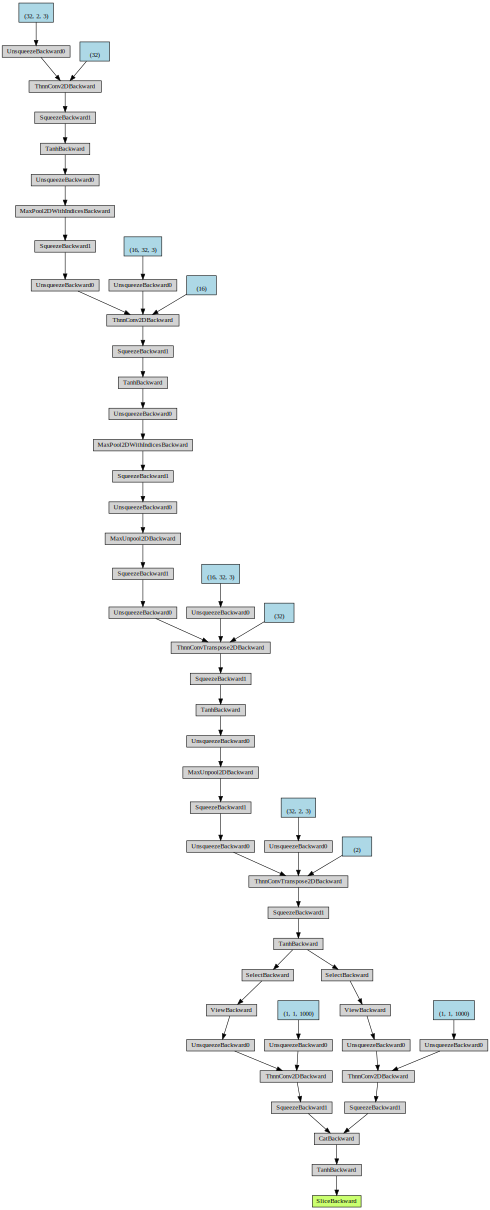

In [596]:
dot